In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("final_dataset.csv")
df.head()

,location-long,location-lat,date,is_foraging,nflh,chl,a_412,bb_412,pic,kd_490,rrs_412,sst
0,-90.905000,28.054000,2014-07-10,1,0.073320,0.602202,0.0889,0.005825,0.000042,0.0770,0.003314,29.900000
1,-91.150922,26.707780,2014-07-11,1,0.049520,0.453073,0.0742,0.005660,0.000020,0.0678,0.002848,31.594999
2,-91.194314,26.693058,2014-07-12,1,0.064395,0.458962,0.0728,0.005605,0.000014,0.0666,0.002246,31.674999
3,-91.434551,26.718662,2014-07-13,1,0.057425,0.544593,0.0953,0.005330,0.000028,0.0736,0.002712,31.324999
4,-91.667210,26.878502,2014-07-14,1,0.067370,0.515926,0.0695,0.006075,0.000154,0.0726,0.004656,30.025000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12916 entries, 0 to 12915
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location-long  12916 non-null  float64
 1   location-lat   12916 non-null  float64
 2   date           12916 non-null  object 
 3   is_foraging    12916 non-null  int64  
 4   nflh           12916 non-null  float64
 5   chl            12916 non-null  float64
 6   a_412          12916 non-null  float64
 7   bb_412         12916 non-null  float64
 8   pic            12916 non-null  float64
 9   kd_490         12916 non-null  float64
 10  rrs_412        12916 non-null  float64
 11  sst            12916 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 1.2+ MB


In [4]:
print("NaN counts per column:")
df.isnull().sum()

NaN counts per column:


location-long    0
location-lat     0
date             0
is_foraging      0
nflh             0
chl              0
a_412            0
bb_412           0
pic              0
kd_490           0
rrs_412          0
sst              0
dtype: int64

In [5]:
rows_with_nan = df[df.isnull().any(axis=1)]
print(f"Number of rows with NaN: {len(rows_with_nan)}")
if len(rows_with_nan) > 0:
    print("First few rows with NaN:")
    rows_with_nan.head()

Number of rows with NaN: 0


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

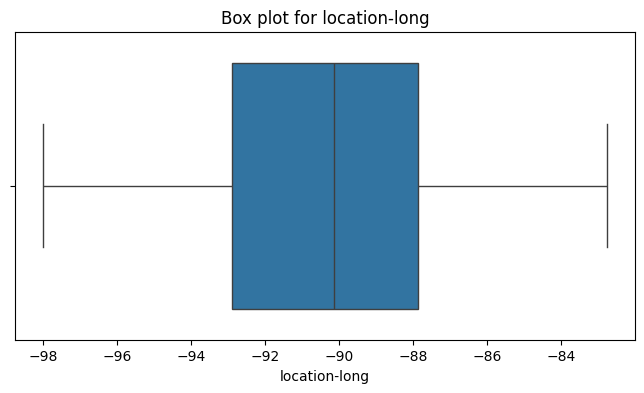

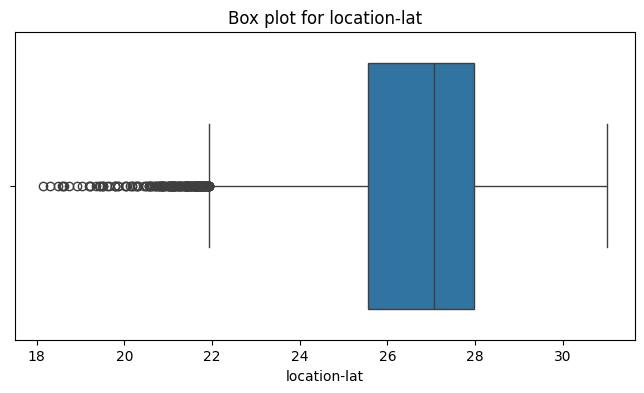

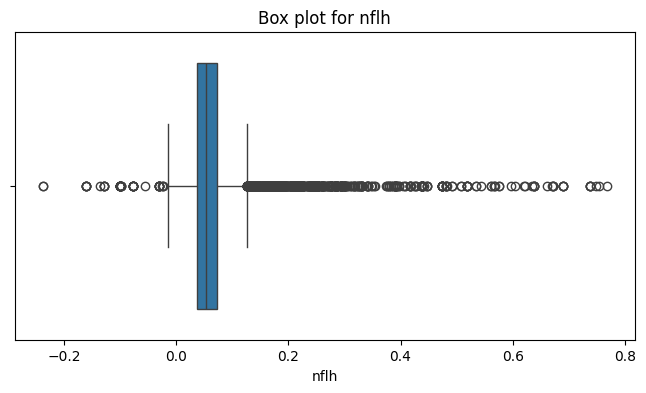

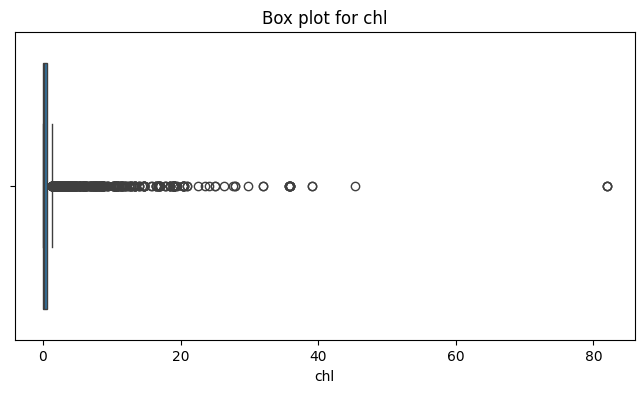

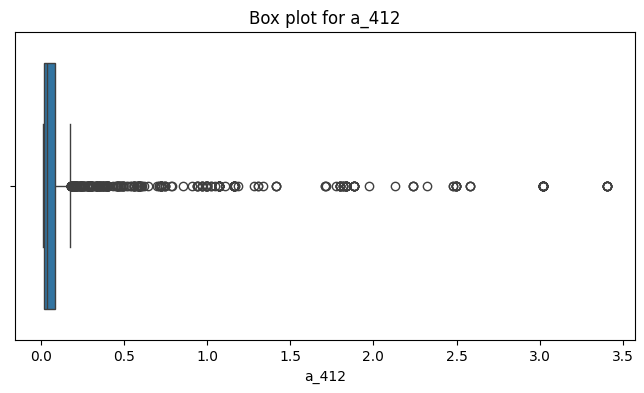

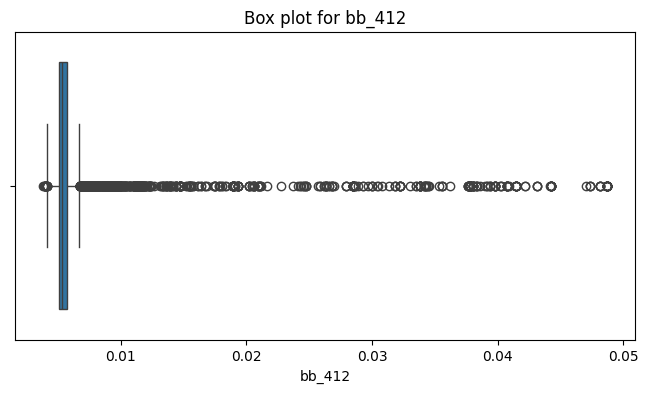

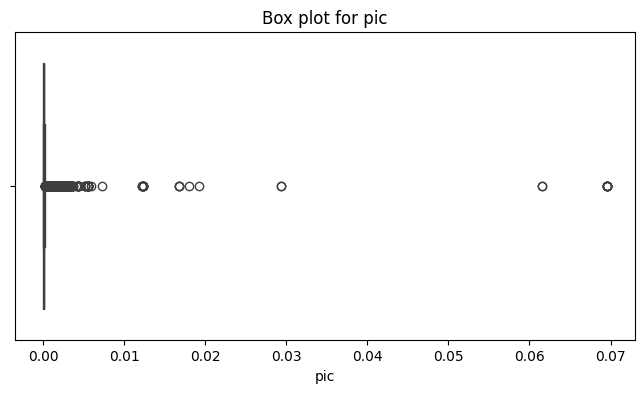

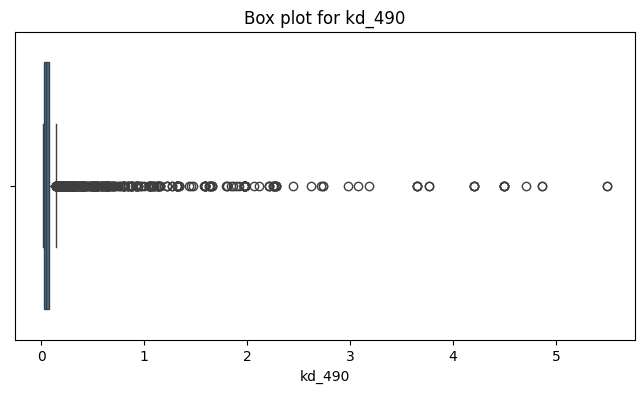

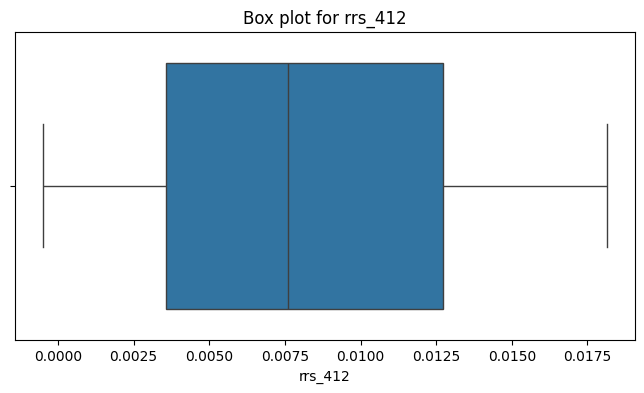

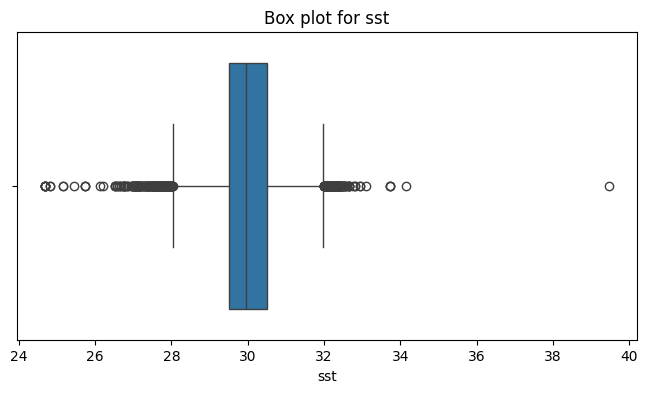

In [5]:
numerical_cols = ['location-long', 'location-lat', 'nflh', 'chl', 'a_412', 'bb_412', 'pic', 'kd_490', 'rrs_412', 'sst']
for col in numerical_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f'Box plot for {col}')
    plt.show()

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import xgboost as xgb
import joblib

In [6]:
# Prepare features and target
features = ['nflh', 'chl', 'a_412', 'bb_412', 'pic', 'kd_490', 'rrs_412', 'sst']
X = df[features]
y = df['is_foraging']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training labels distribution: {y_train.value_counts()}")
print(f"Test labels distribution: {y_test.value_counts()}")

Training set shape: (10332, 8)
Test set shape: (2584, 8)
Training labels distribution: is_foraging
0    5166
1    5166
Name: count, dtype: int64
Test labels distribution: is_foraging
1    1292
0    1292
Name: count, dtype: int64


In [5]:
# Define individual models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
}

# Cross-validation evaluation
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    cv_results[name] = scores
    print(f"{name} CV ROC-AUC: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Logistic Regression CV ROC-AUC: 0.5117 (+/- 0.0148)
Random Forest CV ROC-AUC: 0.5411 (+/- 0.0128)
XGBoost CV ROC-AUC: 0.5421 (+/- 0.0251)


In [6]:
# Train and evaluate individual models on test set
test_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    test_results[name] = {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"\n{name} Test Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Logistic Regression Test Results:
Accuracy: 0.5050
ROC-AUC: 0.5169
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.39      0.44      1292
           1       0.50      0.62      0.56      1292

    accuracy                           0.51      2584
   macro avg       0.51      0.51      0.50      2584
weighted avg       0.51      0.51      0.50      2584


Random Forest Test Results:
Accuracy: 0.5364
ROC-AUC: 0.5509
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.53      0.54      1292
           1       0.54      0.54      0.54      1292

    accuracy                           0.54      2584
   macro avg       0.54      0.54      0.54      2584
weighted avg       0.54      0.54      0.54      2584


XGBoost Test Results:
Accuracy: 0.5325
ROC-AUC: 0.5493
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.53   

In [7]:
# Create ensemble model (Voting Classifier with soft voting for probabilities)
ensemble = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42, max_iter=1000)),
        ('rf', RandomForestClassifier(random_state=42, n_estimators=100)),
        ('xgb', xgb.XGBClassifier(random_state=42, eval_metric='logloss'))
    ],
    voting='soft'
)

# Cross-validation for ensemble
ensemble_cv_scores = cross_val_score(ensemble, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Ensemble CV ROC-AUC: {ensemble_cv_scores.mean():.4f} (+/- {ensemble_cv_scores.std() * 2:.4f})")

# Train ensemble on training data
ensemble.fit(X_train, y_train)

# Evaluate on test set
y_pred_ensemble = ensemble.predict(X_test)
y_pred_proba_ensemble = ensemble.predict_proba(X_test)[:, 1]

ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_roc_auc = roc_auc_score(y_test, y_pred_proba_ensemble)

print(f"\nEnsemble Test Results:")
print(f"Accuracy: {ensemble_accuracy:.4f}")
print(f"ROC-AUC: {ensemble_roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_ensemble))

Ensemble CV ROC-AUC: 0.5448 (+/- 0.0182)

Ensemble Test Results:
Accuracy: 0.5372
ROC-AUC: 0.5535
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.53      0.53      1292
           1       0.54      0.54      0.54      1292

    accuracy                           0.54      2584
   macro avg       0.54      0.54      0.54      2584
weighted avg       0.54      0.54      0.54      2584



In [8]:
# Train final ensemble model on all data
final_model = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42, max_iter=1000)),
        ('rf', RandomForestClassifier(random_state=42, n_estimators=100)),
        ('xgb', xgb.XGBClassifier(random_state=42, eval_metric='logloss'))
    ],
    voting='soft'
)

final_model.fit(X, y)

# Save the model
joblib.dump(final_model, 'foraging_habitat_model.pkl')
print("Model saved as 'foraging_habitat_model.pkl'")

Model saved as 'foraging_habitat_model.pkl'


In [9]:
# Example usage of the saved model
# Load the model
loaded_model = joblib.load('foraging_habitat_model.pkl')

# Example data (replace with actual values)
example_data = {
    'nflh': [0.05],
    'chl': [0.5],
    'a_412': [0.08],
    'bb_412': [0.005],
    'pic': [0.0001],
    'kd_490': [0.07],
    'rrs_412': [0.003],
    'sst': [30.0]
}

example_df = pd.DataFrame(example_data)

# Predict probability
probability = loaded_model.predict_proba(example_df)[:, 1][0]
print(f"Probability of being a foraging habitat: {probability:.4f}")

# Predict class (threshold 0.5)
prediction = loaded_model.predict(example_df)[0]
print(f"Predicted class (1=foraging, 0=not): {prediction}")

Probability of being a foraging habitat: 0.4872
Predicted class (1=foraging, 0=not): 0


In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
# Hyperparameter grids for tuning
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'max_iter': [1000, 2000]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }
}

# Base models for tuning
base_models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
}

In [12]:
# Perform hyperparameter tuning
tuned_models = {}
for name, model in base_models.items():
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(
        model, 
        param_grids[name], 
        cv=5, 
        scoring='roc_auc', 
        n_jobs=-1, 
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    tuned_models[name] = grid_search.best_estimator_
    print(f"Best params for {name}: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    print()

Tuning Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params for Logistic Regression: {'C': 100, 'max_iter': 1000}
Best CV score: 0.5225

Tuning Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params for Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best CV score: 0.5565

Tuning XGBoost...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params for XGBoost: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.8}
Best CV score: 0.5489



In [13]:
# Evaluate tuned models on test set
tuned_test_results = {}
for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    tuned_test_results[name] = {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"\nTuned {name} Test Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Tuned Logistic Regression Test Results:
Accuracy: 0.5132
ROC-AUC: 0.5171
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.41      0.45      1292
           1       0.51      0.62      0.56      1292

    accuracy                           0.51      2584
   macro avg       0.51      0.51      0.51      2584
weighted avg       0.51      0.51      0.51      2584


Tuned Random Forest Test Results:
Accuracy: 0.5294
ROC-AUC: 0.5488
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.48      0.50      1292
           1       0.53      0.58      0.55      1292

    accuracy                           0.53      2584
   macro avg       0.53      0.53      0.53      2584
weighted avg       0.53      0.53      0.53      2584


Tuned XGBoost Test Results:
Accuracy: 0.5368
ROC-AUC: 0.5557
Classification Report:
              precision    recall  f1-score   support

           0      

In [14]:
# Create tuned ensemble model
tuned_ensemble = VotingClassifier(
    estimators=[
        ('lr', tuned_models['Logistic Regression']),
        ('rf', tuned_models['Random Forest']),
        ('xgb', tuned_models['XGBoost'])
    ],
    voting='soft'
)

# Cross-validation for tuned ensemble
tuned_ensemble_cv_scores = cross_val_score(tuned_ensemble, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Tuned Ensemble CV ROC-AUC: {tuned_ensemble_cv_scores.mean():.4f} (+/- {tuned_ensemble_cv_scores.std() * 2:.4f})")

# Train tuned ensemble
tuned_ensemble.fit(X_train, y_train)

# Evaluate on test
y_pred_tuned_ensemble = tuned_ensemble.predict(X_test)
y_pred_proba_tuned_ensemble = tuned_ensemble.predict_proba(X_test)[:, 1]

tuned_ensemble_accuracy = accuracy_score(y_test, y_pred_tuned_ensemble)
tuned_ensemble_roc_auc = roc_auc_score(y_test, y_pred_proba_tuned_ensemble)

print(f"\nTuned Ensemble Test Results:")
print(f"Accuracy: {tuned_ensemble_accuracy:.4f}")
print(f"ROC-AUC: {tuned_ensemble_roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_tuned_ensemble))

Tuned Ensemble CV ROC-AUC: 0.5537 (+/- 0.0195)

Tuned Ensemble Test Results:
Accuracy: 0.5321
ROC-AUC: 0.5557
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.50      0.51      1292
           1       0.53      0.57      0.55      1292

    accuracy                           0.53      2584
   macro avg       0.53      0.53      0.53      2584
weighted avg       0.53      0.53      0.53      2584



In [15]:
# Train final tuned ensemble on all data
final_tuned_model = VotingClassifier(
    estimators=[
        ('lr', tuned_models['Logistic Regression']),
        ('rf', tuned_models['Random Forest']),
        ('xgb', tuned_models['XGBoost'])
    ],
    voting='soft'
)

final_tuned_model.fit(X, y)

# Save the tuned model
joblib.dump(final_tuned_model, 'foraging_habitat_model_tuned.pkl')
print("Tuned model saved as 'foraging_habitat_model_tuned.pkl'")

Tuned model saved as 'foraging_habitat_model_tuned.pkl'


In [16]:
# Example usage of the tuned saved model
# Load the tuned model
loaded_tuned_model = joblib.load('foraging_habitat_model_tuned.pkl')

# Predict probability with tuned model
probability_tuned = loaded_tuned_model.predict_proba(example_df)[:, 1][0]
print(f"Tuned model - Probability of being a foraging habitat: {probability_tuned:.4f}")

# Predict class
prediction_tuned = loaded_tuned_model.predict(example_df)[0]
print(f"Tuned model - Predicted class (1=foraging, 0=not): {prediction_tuned}")

Tuned model - Probability of being a foraging habitat: 0.5296
Tuned model - Predicted class (1=foraging, 0=not): 1


In [3]:
import optuna
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import StackingClassifier
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import StratifiedKFold

c:\Users\chuca\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Advanced Feature Engineering
# Create polynomial features (degree 2, interactions only)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
poly_feature_names = poly.get_feature_names_out(features)
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)

# Add domain-specific features
X_engineered = X_poly_df.copy()
X_engineered['chl_nflh_ratio'] = X['chl'] / (X['nflh'] + 1e-6)  # Avoid division by zero
X_engineered['sst_chl_interaction'] = X['sst'] * X['chl']
X_engineered['kd_rrs_sum'] = X['kd_490'] + X['rrs_412']

print(f"Original features: {len(features)}")
print(f"Engineered features: {X_engineered.shape[1]}")
print("New features added:", [col for col in X_engineered.columns if col not in features])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_engineered)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_engineered.columns)

# Split engineered data
X_train_eng, X_test_eng, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Engineered training set shape: {X_train_eng.shape}")

Original features: 8
Engineered features: 39
New features added: ['nflh chl', 'nflh a_412', 'nflh bb_412', 'nflh pic', 'nflh kd_490', 'nflh rrs_412', 'nflh sst', 'chl a_412', 'chl bb_412', 'chl pic', 'chl kd_490', 'chl rrs_412', 'chl sst', 'a_412 bb_412', 'a_412 pic', 'a_412 kd_490', 'a_412 rrs_412', 'a_412 sst', 'bb_412 pic', 'bb_412 kd_490', 'bb_412 rrs_412', 'bb_412 sst', 'pic kd_490', 'pic rrs_412', 'pic sst', 'kd_490 rrs_412', 'kd_490 sst', 'rrs_412 sst', 'chl_nflh_ratio', 'sst_chl_interaction', 'kd_rrs_sum']
Engineered training set shape: (10332, 39)


In [9]:
# Optuna objectives for hyperparameter optimization
def objective_lr(trial):
    C = trial.suggest_float('C', 1e-4, 1e4, log=True)
    max_iter = trial.suggest_int('max_iter', 1000, 5000)
    
    model = LogisticRegression(C=C, max_iter=max_iter, random_state=42)
    scores = cross_val_score(model, X_train_eng, y_train, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), scoring='roc_auc')
    return scores.mean()

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    scores = cross_val_score(model, X_train_eng, y_train, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), scoring='roc_auc')
    return scores.mean()

def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    scores = cross_val_score(model, X_train_eng, y_train, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), scoring='roc_auc')
    return scores.mean()

def objective_lgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    num_leaves = trial.suggest_int('num_leaves', 10, 200)
    
    model = lgb.LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        num_leaves=num_leaves,
        random_state=42,
        verbosity=-1
    )
    scores = cross_val_score(model, X_train_eng, y_train, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), scoring='roc_auc')
    return scores.mean()

def objective_cb(trial):
    iterations = trial.suggest_int('iterations', 50, 1000)
    depth = trial.suggest_int('depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    
    model = cb.CatBoostClassifier(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=42,
        verbose=False
    )
    scores = cross_val_score(model, X_train_eng, y_train, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), scoring='roc_auc')
    return scores.mean()

In [10]:
# Run Optuna optimizations
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Reduce output

print("Optimizing Logistic Regression...")
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=100, timeout=300)  # 100 trials or 5 min
best_lr = LogisticRegression(**study_lr.best_params, random_state=42)
print(f"Best LR params: {study_lr.best_params}, Score: {study_lr.best_value:.4f}")

print("Optimizing Random Forest...")
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=100, timeout=600)
best_rf = RandomForestClassifier(**study_rf.best_params, random_state=42, n_jobs=-1)
print(f"Best RF params: {study_rf.best_params}, Score: {study_rf.best_value:.4f}")

print("Optimizing XGBoost...")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100, timeout=600)
best_xgb = xgb.XGBClassifier(**study_xgb.best_params, random_state=42, eval_metric='logloss', use_label_encoder=False)
print(f"Best XGB params: {study_xgb.best_params}, Score: {study_xgb.best_value:.4f}")

print("Optimizing LightGBM...")
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=100, timeout=600)
best_lgb = lgb.LGBMClassifier(**study_lgb.best_params, random_state=42, verbosity=-1)
print(f"Best LGB params: {study_lgb.best_params}, Score: {study_lgb.best_value:.4f}")

print("Optimizing CatBoost...")
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(objective_cb, n_trials=100, timeout=600)
best_cb = cb.CatBoostClassifier(**study_cb.best_params, random_state=42, verbose=False)
print(f"Best CB params: {study_cb.best_params}, Score: {study_cb.best_value:.4f}")

# Store best models
best_models = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'XGBoost': best_xgb,
    'LightGBM': best_lgb,
    'CatBoost': best_cb
}

Optimizing Logistic Regression...
Best LR params: {'C': 5.392410924383936, 'max_iter': 1122}, Score: 0.5330
Optimizing Random Forest...
Best RF params: {'n_estimators': 354, 'max_depth': 17, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': 'sqrt'}, Score: 0.5549
Optimizing XGBoost...


C:\Users\chuca\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [02:26:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\chuca\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [02:26:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\chuca\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [02:26:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\chuca\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [02:26:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

Best XGB params: {'n_estimators': 340, 'max_depth': 10, 'learning_rate': 0.0005925658699106287, 'subsample': 0.842954306339466, 'colsample_bytree': 0.9508513565645778}, Score: 0.5542
Optimizing LightGBM...
Best LGB params: {'n_estimators': 634, 'max_depth': 13, 'learning_rate': 0.00010882145349450626, 'subsample': 0.6268873639337113, 'colsample_bytree': 0.5825502928897398, 'num_leaves': 169}, Score: 0.5588
Optimizing CatBoost...
Best CB params: {'iterations': 721, 'depth': 9, 'learning_rate': 0.004901368170251837, 'subsample': 0.860871845300959}, Score: 0.5558


In [11]:
# Evaluate best models on test set
best_test_results = {}
for name, model in best_models.items():
    model.fit(X_train_eng, y_train)
    y_pred = model.predict(X_test_eng)
    y_pred_proba = model.predict_proba(X_test_eng)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    best_test_results[name] = {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"\n{name} Test Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Logistic Regression Test Results:
Accuracy: 0.5058
ROC-AUC: 0.5080
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.35      0.41      1292
           1       0.50      0.66      0.57      1292

    accuracy                           0.51      2584
   macro avg       0.51      0.51      0.49      2584
weighted avg       0.51      0.51      0.49      2584


Random Forest Test Results:
Accuracy: 0.5337
ROC-AUC: 0.5541
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      1292
           1       0.53      0.54      0.54      1292

    accuracy                           0.53      2584
   macro avg       0.53      0.53      0.53      2584
weighted avg       0.53      0.53      0.53      2584



C:\Users\chuca\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [03:02:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Test Results:
Accuracy: 0.5302
ROC-AUC: 0.5512
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.49      0.51      1292
           1       0.53      0.57      0.55      1292

    accuracy                           0.53      2584
   macro avg       0.53      0.53      0.53      2584
weighted avg       0.53      0.53      0.53      2584


LightGBM Test Results:
Accuracy: 0.5271
ROC-AUC: 0.5473
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.50      0.51      1292
           1       0.53      0.55      0.54      1292

    accuracy                           0.53      2584
   macro avg       0.53      0.53      0.53      2584
weighted avg       0.53      0.53      0.53      2584


CatBoost Test Results:
Accuracy: 0.5271
ROC-AUC: 0.5440
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.47      0.50      129

In [12]:
# Create advanced ensemble with stacking
base_estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('lgb', best_lgb),
    ('cb', best_cb)
]

# Stacking ensemble
stacking_ensemble = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(random_state=42, max_iter=1000),
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    n_jobs=-1
)

print("Training stacking ensemble...")
stacking_ensemble.fit(X_train_eng, y_train)

# Evaluate stacking ensemble
y_pred_stacking = stacking_ensemble.predict(X_test_eng)
y_pred_proba_stacking = stacking_ensemble.predict_proba(X_test_eng)[:, 1]

stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
stacking_roc_auc = roc_auc_score(y_test, y_pred_proba_stacking)

print(f"\nStacking Ensemble Test Results:")
print(f"Accuracy: {stacking_accuracy:.4f}")
print(f"ROC-AUC: {stacking_roc_auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_stacking))

Training stacking ensemble...

Stacking Ensemble Test Results:
Accuracy: 0.5236
ROC-AUC: 0.5514
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.49      0.51      1292
           1       0.52      0.56      0.54      1292

    accuracy                           0.52      2584
   macro avg       0.52      0.52      0.52      2584
weighted avg       0.52      0.52      0.52      2584



In [13]:
# Train final stacking model on all engineered data
X_all_eng = scaler.transform(X_engineered)  # Scale all data
X_all_eng_df = pd.DataFrame(X_all_eng, columns=X_engineered.columns)

final_stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(random_state=42, max_iter=1000),
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    n_jobs=-1
)

final_stacking_model.fit(X_all_eng_df, y)

# Save the final model and scaler
joblib.dump(final_stacking_model, 'foraging_habitat_model_intensive.pkl')
joblib.dump(scaler, 'scaler_intensive.pkl')
joblib.dump(poly, 'poly_features.pkl')  # Save polynomial transformer

print("Intensive model saved as 'foraging_habitat_model_intensive.pkl'")
print("Scaler saved as 'scaler_intensive.pkl'")
print("Polynomial features saved as 'poly_features.pkl'")

Intensive model saved as 'foraging_habitat_model_intensive.pkl'
Scaler saved as 'scaler_intensive.pkl'
Polynomial features saved as 'poly_features.pkl'


In [14]:
# Example usage of the intensive model
# Load components
loaded_intensive_model = joblib.load('foraging_habitat_model_intensive.pkl')
loaded_scaler = joblib.load('scaler_intensive.pkl')
loaded_poly = joblib.load('poly_features.pkl')

# Prepare example data (original features)
example_data_intensive = {
    'nflh': [0.05],
    'chl': [0.5],
    'a_412': [0.08],
    'bb_412': [0.005],
    'pic': [0.0001],
    'kd_490': [0.07],
    'rrs_412': [0.003],
    'sst': [30.0]
}

example_df_intensive = pd.DataFrame(example_data_intensive)

# Apply feature engineering
example_poly = loaded_poly.transform(example_df_intensive)
example_poly_df = pd.DataFrame(example_poly, columns=loaded_poly.get_feature_names_out(features))

# Add domain features
example_poly_df['chl_nflh_ratio'] = example_df_intensive['chl'] / (example_df_intensive['nflh'] + 1e-6)
example_poly_df['sst_chl_interaction'] = example_df_intensive['sst'] * example_df_intensive['chl']
example_poly_df['kd_rrs_sum'] = example_df_intensive['kd_490'] + example_df_intensive['rrs_412']

# Scale
example_scaled = loaded_scaler.transform(example_poly_df)

# Predict
probability_intensive = loaded_intensive_model.predict_proba(example_scaled)[:, 1][0]
prediction_intensive = loaded_intensive_model.predict(example_scaled)[0]

print(f"Intensive model - Probability of being a foraging habitat: {probability_intensive:.4f}")
print(f"Intensive model - Predicted class (1=foraging, 0=not): {prediction_intensive}")

C:\Users\chuca\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\chuca\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\chuca\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\chuca\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\chuca\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid featu

Intensive model - Probability of being a foraging habitat: 0.5611
Intensive model - Predicted class (1=foraging, 0=not): 1
